<a href="https://colab.research.google.com/github/Ahmetyldrr/LLM-Models-Pratic/blob/main/Chapter5_Fine_Tuning_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proje Amacı

Açıklamalara ve kod parçacıklarına baktığımızda, temelde kullanıcı yorumlarına dayalı bir metin sınıflandırma projesi yürütüldüğünü görüyoruz. Özellikle:

Veri kümesinde her bir yorumun metni (review) ve bir yıldız (star) değeri bulunuyor (1–5 gibi).

Kod içerisinde star sütunu “label” olarak yeniden adlandırılıyor ve bu kolon sınıflandırma etiketleri (ClassLabel) haline getiriliyor.

Ardından çeşitli transformer tabanlı modeller (DistilBERT, GPT-3.5, Babbage vb.) veya farklı epoch sayıları denenerek, bu yorumların yıldız derecesini tahmin etmeye çalışılıyor.

Çıktı olarak “accuracy” metrikleri hesaplanıyor ve bir tabloda kıyaslanıyor.

Dolayısıyla:

**Projenin Türü:**

Bir metin sınıflandırma (text classification) projesi. Daha spesifik olarak, kullanıcı yorumlarından yola çıkarak “yıldız” tahmini yapan bir derecelendirme/duygu analizi türü diyebiliriz.

**Amaç (Niyet):**

Farklı modellerin (örneğin BERT, GPT-3.5, vb.) aynı veri kümesinde ne kadar başarılı sonuçlar verdiğini görmek.

Bu başarı (performans), “accuracy” (doğruluk) gibi metriklerle ölçülüyor.

Hangi modelin veya hangi eğitim ayarlarının (epoch sayısı, prompt kullanımı vb.) en iyi sonucu verdiğini tespit ederek, yıldız tahmininde en yüksek isabet oranına ulaşmak amaçlanıyor.

Özetle, veriler “review” ve “star” formatında olduğu için kullanıcı yorumlarından yıldız / puanlama sınıflandırması yapan bir NLP (Doğal Dil İşleme) projesi yürütülmüş. Buradaki tüm kod ve değerlendirme adımları, o sınıflandırma görevini daha iyi gerçekleştirecek en uygun modeli veya ayarları seçmek için yapılmıştır.

## İmport İşlemleri

In [3]:
!pip install evaluate datasets transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
import evaluate
import numpy as np
import random

## Dataset İndir

In [43]:
# "star" is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Import the ClassLabel and load_dataset
from datasets import ClassLabel, load_dataset

# Loading the "app_reviews" dataset's training split
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column to a ClassLabel
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset


Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [50]:
dataset[7]

{'package_name': 'com.mantz_it.rfanalyzer',
 'review': 'Works with RTL and Nextbook Aries 8. Demod stops working if the scan width is changed requiring restart.',
 'date': 'May 19 2016',
 'star': 4}

## Datayı Train ve Test Ayır

In [6]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.


# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)

dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

## DistilBert base cased Modeli Tokenize Yap

tokenizer = AutoTokenizer.from_pretrained(MODEL) satırı, Hugging Face Transformers ekosisteminde DistilBERT modeline uygun tokenizer nesnesini oluşturmak amacıyla kullanılan bir adımdır. Aşağıda bu işlemin detayları yer almaktadır:

**Model Adı (MODEL)**

'distilbert-base-cased' ifadesi, DistilBERT’in küçük boyutlu ve kelime büyük-küçük harf duyarlılığı (cased) olan bir sürümünü belirtir.

Bu modelin tokenizer’ı da aynı isimle Hugging Face model hub’da (veya önceden indirdiğiniz bir önbellekte) bulunur.

**Hangi İşlevi Görür?**

AutoTokenizer.from_pretrained(MODEL), model ismine göre doğru tokenizer sınıfını otomatik olarak belirler ve indirilmiş tokenizer dosyalarını kullanarak bir AutoTokenizer nesnesi döndürür.

Bu tokenizer, metni BERT tabanlı modellerin anlayacağı token dizilerine çevirir. Yani, normal cümleleri parçalara ayırır (input_ids, attention_mask gibi tensörler üretir).

**Pratikte Ne İşe Yarar?**

Modeli eğitirken veya tahmin yaparken, ham metin (string) doğrudan modele beslenemez.

Tokenizer, metindeki kelimeleri ya da kelime parçacıklarını sayısal ifadelere (token id) dönüştürür.

Örnek olarak, "DistilBERT bir harika" gibi bir cümle, tokenizer aracılığıyla [101, 8592, 12345, 103, ...] benzeri bir diziye dönüşür. Model de ancak bu sayısal ifadelere bakarak işlem yapar.

**Özet**

AutoTokenizer.from_pretrained(MODEL) çağrısı, DistilBERT’in tokenizer dosyalarını otomatik olarak bulur, indirir (eğer önceden indirilmemişse) ve Belleğe alır.

Sonrasında bu tokenizer nesnesini kullanarak veri setinizdeki metinleri eğitim veya tahmin öncesinde hızlıca dönüştürebilirsiniz.

Bu yüzden ilgili satır, BERT/DistilBERT gibi Transformer modelleriyle çalışırken metinleri sayısal tokenize etme adımını başlatan temel adımdır.

In [7]:
MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

## Preprocess Fonksiyonu

preprocess_function fonksiyonu, ham metin verisini (örneğin "review" sütununu) model için sayısal hale getiren tokenizasyon adımını yapar. Hugging Face Datasets kütüphanesi içerisinde .map(...) gibi yöntemlerle kullanarak, her bir örneğin metin sütununu (örnek: "review") otomatik olarak tokenize edebilirsiniz. Bu fonksiyonun içindeki tokenizer(examples["review"], truncation=True) satırının amacı şöyledir:

**Ham Metni Sayısal Input’a Dönüştürme**

Modeller ham metin dizelerini doğrudan işleyemez.

Tokenizer, kelimeleri veya kelime parçalarını input_ids, attention_mask gibi sayısal tensörlere çevirerek bu metinleri modelin anlayacağı hale getirir.

**Truncation (Kesme)**

Transformer modelleri genellikle belirli bir maksimum dizi uzunluğu (örneğin 128, 256 vb.) ile eğitilirler.

truncation=True parametresi, metnin bu maksimum uzunluğu aşması durumunda fazlalıkları keserek modele uygun uzunluğa indirger.

Bu sayede modeller, çok uzun metinlerden dolayı hata vermeden veya aşırı bellek tüketmeden eğitime/devama olanak tanır.

.map(...) ile Toplu (Batch) İşleme

Datasets kütüphanesi, veri setini parçalar hâlinde döngüye sokmadan .map(...) metoduyla bu fonksiyonu bütün örneklere otomatik olarak uygular.

Böylece tüm veri seti, tek satırlık kodla tokenize edilmiş olur.

**Girdi Hazırlığı**

Bu işlem sonucunda veri kümesi satırlarında, modelin kullanacağı (input_ids, attention_mask gibi) alanlar eklenmiş şekilde yer alır.

Ardından bu veri kümesi, eğitim, değerlendirme veya tahmin aşamasında direkt olarak modele beslenebilir.

Özetle, preprocess_function sayesinde "review" gibi ham metin kolonlarını hızlıca tokenizer’dan geçirip, modelin beklediği sayısal formatı elde edersiniz. Bu, herhangi bir BERT veya DistilBERT benzeri Transformer modelinde eğitim/tahmin yapabilmek için gerekli olan temel bir adımdır.

In [8]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):  # each example is an element from the Dataset
    return tokenizer(examples["review"], truncation=True)

## data_collator

Hugging Face Transformers ekosisteminde, DataCollatorWithPadding bir veri düzenleme (collation) işlemi yapan yardımcı sınıftır. Veri kümelerini (özellikle farklı uzunluklarda token dizileri içeren metinleri) mini-batch’lere bölerken, otomatik olarak en uzun dizinin boyutuna göre diğer dizileri padding (dolgu) yapar. Böylece tüm örnekler, bir batch içerisinde aynı boyuta sahip olur ve model tarafından kolayca işlenebilir.

**Detaylı Açıklama**

**Farklı Uzunluk Sorunu:**
Transformer tabanlı modellerde her girdi (örneğin input_ids) aynı boyutta (sequence length) olmalıdır. Ancak gerçek veri kümesindeki metinler (tokenleştirilmiş haliyle) çok farklı uzunluklara sahip olabilir.

**Otomatik Dolgu (Padding):**

DataCollatorWithPadding, bir batch (örneğin 8 veya 16 örnek) oluşturulurken, en uzun sekans kaç token içeriyorsa, diğer daha kısa sekansları da o boya çıkaracak şekilde PAD tokeni ile doldurur.

Böylelikle model, batch içindeki her örnek için aynı boyutta bir tensör elde eder.

**Tokenizer ile Entegrasyon:**

DataCollatorWithPadding(tokenizer=...) argümanı sayesinde, hangi tokenizer’ın PAD tokeni veya max_length parametresini kullanacağını bildirmiş olursunuz.

Bu sayede modelin “padding index” değerini (ör. 0, 1 gibi) otomatik olarak doğru biçimde ayarlar.

**Avantaj:**

Elle sabit bir max_length belirlemek zorunda kalmazsınız.

Her batch’deki en uzun örnek kadar dinamik olarak padding yapıldığından, genel bellek tüketimi de genelde optimize olur (sabit bir uzunluk belirleyip bütün örnekleri o boyuta şişirmekten daha verimli olabilir).

Özetle, DataCollatorWithPadding sınıfı, varyan sekans uzunluklarına sahip metinleri modelin işleyebileceği sabit boyutlu tensörlere dönüştürmek amacıyla otomatik padding işlemini üstlenir. Bu, eğitim ve değerlendirme döngülerinde batch oluşturmayı ciddi biçimde kolaylaştırır.

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

## sequence_clf_model

Bu satır, Hugging Face’in AutoModelForSequenceClassification sınıfını kullanarak, belirtilen MODEL (örneğin 'distilbert-base-cased', 'bert-base-uncased' vb.) adındaki önceden eğitilmiş (pretrained) ağırlıkları yüklüyor ve sekans sınıflandırma (SequenceClassification) görevine uygun bir model nesnesi oluşturuyor.

**Detaylar**
**Önceden Eğitilmiş Modelin Yüklenmesi**

from_pretrained(MODEL) metodu, Hugging Face model hub’dan (veya daha önce lokal olarak indirdiğiniz önbellekten) ilgili ağırlıkları getirir.

Bu sayede model, büyük bir metin korpusunda eğitim almış (örneğin BERT, DistilBERT, vb.) parametreleri kullanır.

**Sınıflandırma Katmanı (Classification Head)**

AutoModelForSequenceClassification sınıfı, taban (base) modele ek olarak sınıflandırma için özel bir katman (genellikle bir Dense/Linear katman) ekler.

num_labels=5 argümanı, bu son katmanın 5 çıkış nöronuna (5 sınıf/etiket) sahip olacağını belirtir.

Metin sınıflandırma (örneğin “1 yıldız–5 yıldız” derecelendirme) gibi görevlerde bu çıkış katmanı modelin tahmin edeceği sınıf sayısını belirler.

**Kullanım Örneği**

Eğer elinizde 5 sınıflı bir duygu analizi (emotion classification) veya 5 yıldızlı bir değerlendirme (review rating) görevi varsa, bu modelin logits çıktısı [batch_size, 5] boyutunda olur.

Argmax işlemi yaparak en yüksek skora sahip sınıfı (0–4 aralığında) bulabilirsiniz.

**Avantajı**

Hugging Face ekosisteminde hazır bulunan AutoModelForSequenceClassification, sınıflandırma işlevini tek adımda kullanıma hazır hâle getirir.

Örneğin, loss hesaplamalarını (CrossEntropyLoss) da otomatik üstlenerek eğitim sırasında hedef etiketlerle (labels) karşılaştırma yapabilir.

Kısacası, bu kod satırı önceden eğitilmiş bir Transformer modelini (BERT, DistilBERT vb.) 5 sınıflı bir sınıflandırma görevine uyarlamanız (fine-tuning) için hazır hâle getirir.

In [10]:
sequence_clf_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5,
)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
sequence_clf_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Dataset Map

In [12]:
dataset = dataset.map(preprocess_function, batched=True)
dataset

Map:   0%|          | 0/172839 [00:00<?, ? examples/s]

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

dataset.map(preprocess_function, batched=True) çağrısı, Hugging Face Datasets yapısı üzerindeki her bir örneğe (veya belirli boyuttaki gruplara / “batch”lere) preprocess_function adlı fonksiyonu uygulayarak dönüştürme işlemi yapar. Bu örnekte, fonksiyon metin sütununu tokenize eder veya gereken ön işlemleri gerçekleştirir. Aşağıda detaylar mevcuttur:

**Hangi Fonksiyon Uygulanıyor?**

preprocess_function daha önce tanımladığınız ve ham metni (örneğin review sütununu) tokenizer’dan geçirerek input_ids, attention_mask gibi sayısal formatta çıktı üreten fonksiyonunuzdur.

**map Metodu**

Hugging Face Datasets içindeki .map(...) metodu, veri kümesinin her örneğine (veya batched=True ise belirtilen boyuttaki gruplarına) fonksiyonu otomatik olarak uygular.

Sonuçta, orijinal sütunlara ek olarak tokenize edilmiş veriyi ek sütunlar şeklinde veri kümenize dahil eder.

**batched=True Parametresi**

Örneklerinizin boyutuna göre (örneğin 1000 veya 10.000 satır) .map fonksiyonu, her bir alt parçayı (batch) işlemden geçirir.

Bu, tek tek işleme göre daha hızlı ve verimli olabilir.

**Sonuç**

dataset = ... ifadesiyle, işlem sonucunda üretilen yeni veri kümesinin tamamını dataset değişkeninde saklamış olursunuz.

Artık veri kümesi, tokenize edilmiş (input_ids, attention_mask) veri sütunlarını da içerir ve modelinize uygun hale gelir.

Özetle, bu satır metinleri modelin anlayacağı “sayısal” formata dönüştürürken, veri kümesinin yapısını koruyarak kalıcı bir şekilde günceller.

## Veri Düzeltme



Veri kümenizdeki "star" adlı sütunu "label" olarak yeniden adlandırıyorsunuz.

Sınıflandırma veya etiketleme görevlerinde sütunun adının "label" olması, özellikle Hugging Face’in Trainer gibi bazı otomatik süreçlerinde pratiklik sağlar.

Gereksiz Sütunları Silme (Remove Columns)

Model eğitimi veya tahmin aşamasında bu sütunlara ihtiyacınız olmadığı için gereksiz alanları temizlemiş oluyorsunuz.

Geriye sadece ihtiyaç duyulan sütunları (örneğin label, input_ids, attention_mask vb.) bırakarak veri setini daha sade hale getiriyorsunuz.

Bu işlemler sonucunda, veri kümesindeki gerekli sütunlar (özellikle modelin girdi ve etiket sütunları) hazır kalırken, fazlalık olan sütunlar ayıklanmış oluyor.

In [13]:
dataset = dataset.rename_column("star", "label")
dataset = dataset.remove_columns(['package_name', 'review', 'date'])
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

## GÖrselleştirme

Bu kod parçacığı, eğitim veri kümesindeki (dataset['train']) tokenize edilmiş girişlerin (input_ids) uzunluk dağılımını görmek için bir histogram çiziyor. Detaylı adımlar şöyle:

**input_ids Değişkeni**

input_ids = dataset['train']['input_ids']

input_ids, tokenize edilmiş her bir eğitim örneği için token dizisi (liste halinde token kimlikleri) içerir. Örneğin, [101, 234, 56, ...] şeklinde.

**Pandas Series**

pd.Series(input_ids)

Python listesini bir Pandas Series’e çevirir; her satır bir örneğe (token dizisine) karşılık gelir.

**Uzunluk Hesaplama**

.apply(len)

Her bir örnekteki token sayısını (yani o liste kaç öğe içeriyor) hesaplar.

Sonuçta, her satır “token dizisi uzunluğu” olarak depolanır.

**Histogram**

.hist()

Elde edilen uzunluk değerlerinin sıklık dağılımını görselleştirir.

Örneğin çok fazla örneğin ~128 token uzunluğunda toplanıp toplanmadığını veya maksimum/minimum değerleri nasıl bir aralıkta olduğunu tespit edebilirsiniz.

Özetle, bu işlem, eğitim verisindeki tüm metinlerin (tokenize edildikten sonra) kaç token uzunluğuna sahip olduğunu gösteren bir histogram üretir. Bu, modelinize uygun maksimum sekans uzunluğu veya padding ayarları yaparken yol gösterici olabilir.

<Axes: >

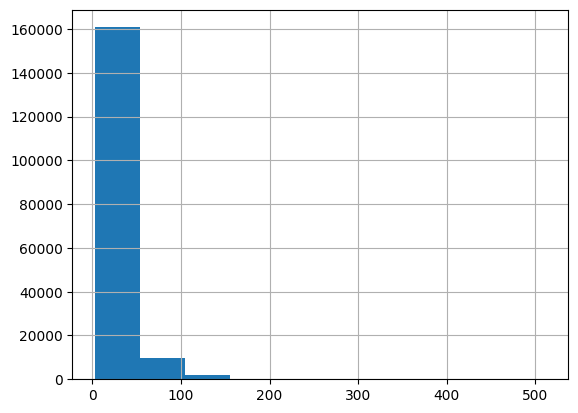

In [14]:
import pandas as pd

input_ids = dataset['train']['input_ids']
pd.Series(input_ids).apply(len).hist()

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

## Metric İnceleme

Bu fonksiyon, eğitim veya değerlendirme sırasında modelin performansını ölçmek için hesaplanan metrikleri döndürüyor. Özellikle burada:

**Argmax ile Tahmin Elde Edilmesi**

preds = np.argmax(p.predictions, axis=1)

Modelin ham çıktılarını (logit veya olasılık değerlerini) göz önünde bulundurarak en yüksek skora sahip sınıfın indeksini tahmin (pred) olarak belirliyor.

**Doğruluğun (Accuracy) Hesaplanması**

(preds == p.label_ids).mean()

Tahmin edilen etiketlerle (preds) gerçek etiketleri (p.label_ids) karşılaştırıyor.

Eşleşen etiketlerin oranı, doğruluk (accuracy) olarak dönüyor.

**compute_metrics**

Çıktısı bir sözlük (dictionary) formunda metrik değerleri içerir, örneğin {"accuracy": 0.85} gibi.

Bu fonksiyon, Hugging Face Trainer gibi araçlarda compute_metrics parametresine verilerek eğitim/validasyon sırasında düzenli raporlama yapmasını sağlar.

In [16]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

## Eğitim Süreci

Eğitim Sürecini Adım Adım Açıklama (Markdown Biçiminde)

**1. Epoch Sayısının Ayarlanması**

Belirli bir döngü boyunca (epoch) verinin tamamı üzerinde modelin eğitilmesini sağlamak için bir epoch sayısı belirlenir.

Örneğin 1 epoch, veri kümesini sadece 1 kez gezerek model güncellemeleri yapar.

**2. Eğitim Parametrelerinin Tanımlanması (TrainingArguments)**

Çıktıların ve ara modellerin kaydedileceği bir klasör yolu seçilir.

Kaç epoch döngüsü yapılacağı, batch boyutu (her adımda kaç örneğin modele verileceği) gibi temel hiperparametreler tanımlanır.

Bu aşamada ayrıca gradient accumulation (belirli adım sayısı toplandıktan sonra geri yayılım), warmup ratio (öğrenme oranının kademeli artacağı oran), weight decay (düzenleme katsayısı) gibi ileri seviye ayarlar da yapılabilir.

Hangi adımlarda ya da hangi sıklıkta loglama ve değerlendirme (evaluation) yapılacağı belirtilir.

load_best_model_at_end gibi bir seçenekle, eğitim bittiğinde doğrulama setinde en iyi performansı gösteren kontrol noktasının yüklenmesi sağlanır.

**3. Trainer Nesnesinin Hazırlanması**

Model, belirlenmiş eğitim parametreleri (TrainingArguments) ile birlikte Trainer içine alınır.

Eğitimin hangi veri kümesi üzerinde (örneğin train), hangi doğrulama veri kümesi üzerinde (örneğin val) yapılacağı gösterilir.

Eğer metrik hesaplama fonksiyonunuz (örneğin accuracy ölçümü) varsa, bu fonksiyon da Trainer’a eklenir.

Data collator gibi yardımcı işlemlerle, farklı boyutlardaki token dizileri aynı boyuta getirilerek (padding) modele uygun biçimde beslenebilir.

**4. Eğitimi Başlatma ve İzleme**

Tüm bu adımlar tamamlandıktan sonra, Trainer nesnesi aracılığıyla model eğitim süreci (trainer.train()) başlatılır.

Her epoch sonrasında belirli loglamalar, değerlendirmeler (örneğin doğrulama seti üzerinde metrik hesaplama) ve kontrol noktası (checkpoint) kaydetme işlemleri otomatik yapılır.

Eğitim bittiğinde, en iyi doğrulama performansına sahip model ağırlıkları saklanarak ileri kullanım için hazır olur.

### Epoch Değişkeni

Açıklama

epochs isimli bir değişken tanımlanır ve 1 olarak ayarlanır.


Bu değer, modelin veri kümesini yalnızca bir tam tur (1 epoch) eğitmesi anlamına gelir.


Daha fazla eğitim döngüsü için epochs değerini arttırabilirsiniz.

### TrainingArguments Tanımlama

**Açıklama**

output_dir="./bert_clf_results"

Eğitimin kayıtlarının (loglar) ve ara model dosyalarının saklanacağı klasörü belirtir.

**num_train_epochs=epochs**

Eğitim döngüsünün kaç kez tekrarlanacağını gösterir. Yukarıda tanımlanan epochs değeri burada kullanılır.

**per_device_train_batch_size=16**

Eğitim sırasında her bir GPU/CPU için batch boyutunu 16 olarak ayarlar.

**gradient_accumulation_steps=2**

İki adımlık gradyanların toplanması sonucu tek bir geri yayılım (backprop) yapılmasını sağlar. Bellek kullanımını optimize etmede yardımcı olur.

**per_device_eval_batch_size=32**

Doğrulama (validation) veya test aşamasında batch boyutunu 32 olarak ayarlar.

**load_best_model_at_end=True**

Eğitim sonunda en yüksek doğrulama başarısını (veya seçilen metrikteki en iyi skoru) elde eden modelin yüklenmesini otomatikleştirir.

**warmup_ratio=0.1**

Tüm eğitim adımlarının %10’u kadar bir ısınma (warmup) aşaması tanımlar. Öğrenme oranını bu süreçte kademeli olarak artırır.

**weight_decay=0.05**

Model ağırlıklarının güncellenmesi esnasında bir düzenleme (regularization) yöntemi olan weight decay’i uygular.

**logging_steps=1, log_level='info'**

Her bir adımda bir log bilgisi yazdırır. Detay seviyesi info olarak ayarlanır.

**evaluation_strategy='epoch'**

Her epoch sonunda otomatik olarak doğrulama metriklerinin ölçülmesini sağlar.

**eval_steps=50**

Aslında evaluation_strategy='epoch' seçiliyse ana rolü biraz isteğe bağlı kalır; fakat 'steps' stratejisinde kullanılması durumunda her 50 adımda bir değerlendirme yapardı.

**save_strategy='epoch'**

Her epoch sonunda model için bir checkpoint (kayıt) oluşturur.

### Trainer Nesnesi

**model=sequence_clf_model**

Eğitilecek veya tahmin yapılacak olan asıl modeli belirtir (örneğin bir BERT, DistilBERT vb. sınıflandırma modeli).

**args=training_args**

Bir önceki adımda tanımladığınız tüm hiperparametrelerin ve ayarların bulunduğu training_args nesnesi, eğitimi yöneten Trainer sınıfına aktarılır.

**train_dataset=dataset['train']**

Eğitim için kullanılacak veri kümesini belirtir (örneğin dataset['train']).

**eval_dataset=dataset['val']**

Doğrulama (validation) işlemleri için kullanılacak veri kümesini belirtir (dataset['val']).

**compute_metrics=compute_metrics**

Eğitim boyunca veya sonrasında, modelin performansını ölçmek için kullanılacak metrik hesaplama fonksiyonu (örneğin accuracy).

**data_collator=data_collator**

Farklı uzunluklardaki metinleri aynı boyutta batch haline getirmek (padding) için kullanılan yardımcı fonksiyon veya sınıftır.

Bu sayede modele giren tüm tensörlerin boyutu tutarlı olur.

Bu adımlardan sonra **trainer.train(**) komutu ile modeli eğitebilirsiniz.

Eğitim döngüsü sırasında belirtilen log, değerlendirme ve checkpoint ayarları devreye girer.

Eğitim sonunda, en iyi doğrulama skoruna sahip olan model otomatik olarak yükleneceğinden, model performansınızı kayıpsız bir şekilde kullanıma hazır hale getirebilirsiniz.

In [17]:
epochs = 1

training_args = TrainingArguments(
    output_dir="./bert_clf_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,

    # some deep learning parameters that the Trainer is able to take in
    warmup_ratio=0.1,
    weight_decay = 0.05,

    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator  # technically optional
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Train Evaluate

**trainer.evaluate()**, Hugging Face’in Trainer sınıfına ait bir metoddur ve şu amaçla kullanılır:

**Eğitim Sonrası Performans Ölçümü:**

Modelin evaluation (değerlendirme) veri kümesindeki performansını görmek için çağrılır.

Bu sayede, modelin eğitimde öğrendiği parametrelerin gerçek dünyadaki/eldeki değerlendirme verisi üzerinde ne kadar başarılı olduğunu ölçebilirsiniz.

**Metrik Hesaplama:**

Trainer tanımlanırken compute_metrics fonksiyonu sağlanmışsa, accuracy, F1 gibi metrikler trainer.evaluate() çağrıldığında otomatik olarak hesaplanır.

Metot, bu metriklerin değerlerini bir sözlük (dictionary) şeklinde döndürür.

**Overfitting veya Model Gelişimi Analizi:**

Eğitim boyunca log’ladığınız veya eğitim sonrası tek seferlik trainer.evaluate() ile aldığınız sonuçlara bakarak, modelin overfitting yaşayıp yaşamadığını veya hangi epochta en iyi performansa ulaştığını değerlendirirsiniz.

**Özetle, trainer.evaluate()**, modelin eval_dataset üzerinde tahmin yapmasını, bu tahminlerle gerçek etiketleri karşılaştırmasını ve sonuçta metrikleri (örn. doğruluk, F1) döndürmesini sağlar. Bu, eğitim sürecinde veya sonrasında modelin nasıl performans gösterdiğini görebilmeniz için gerekli temel adımdır.









In [18]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahmetyildirir1 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.6459993124008179,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.1290333778834638,
 'eval_runtime': 149.4148,
 'eval_samples_per_second': 385.591,
 'eval_steps_per_second': 12.054}

In [19]:
trainer.train()

***** Running training *****
  Num examples = 172,839
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 5,401
  Number of trainable parameters = 65,785,349


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
0,1.027100,0.818365,0.002400,0.716071



***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


Saving model checkpoint to ./bert_clf_results/checkpoint-5401
Configuration saved in ./bert_clf_results/checkpoint-5401/config.json
Model weights saved in ./bert_clf_results/checkpoint-5401/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./bert_clf_results/checkpoint-5401/tokenizer_config.json
Special tokens file saved in ./bert_clf_results/checkpoint-5401/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_clf_results/checkpoint-5401 (score: 0.8183654546737671).


TrainOutput(global_step=5401, training_loss=0.8730273631916424, metrics={'train_runtime': 1348.1386, 'train_samples_per_second': 128.206, 'train_steps_per_second': 4.006, 'total_flos': 3506405066166240.0, 'train_loss': 0.8730273631916424, 'epoch': 0.9999074331204295})

In [20]:
trainer.evaluate(dataset['test'])


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


{'eval_loss': 0.8124272227287292,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.7174075295506223,
 'eval_runtime': 159.3489,
 'eval_samples_per_second': 361.553,
 'eval_steps_per_second': 11.302,
 'epoch': 0.9999074331204295}

In [21]:
import pandas as pd
# Create a dictionary with your data

data = {
    'Model Description': [
        'Babbage - 1 epoch',
        'Babbage - 4 epochs',
        '3.5 - 1 epoch + no system prompt',
        '3.5 - 1 epoch + system prompt',
        'DistilBERT'
    ],
    'Raw Accuracy': [
        0.6467637512367,
        0.6320795653758701,
        0.6345442868796973,
        0.6442296009581171,
        0.71723395761
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# To make it more readable, let's round the numeric values to a fixed number of decimal places:
df_rounded = df.round(5)
df_rounded

,Model Description,Raw Accuracy
0,Babbage - 1 epoch,0.64676
1,Babbage - 4 epochs,0.63208
2,3.5 - 1 epoch + no system prompt,0.63454
3,3.5 - 1 epoch + system prompt,0.64423
4,DistilBERT,0.71723


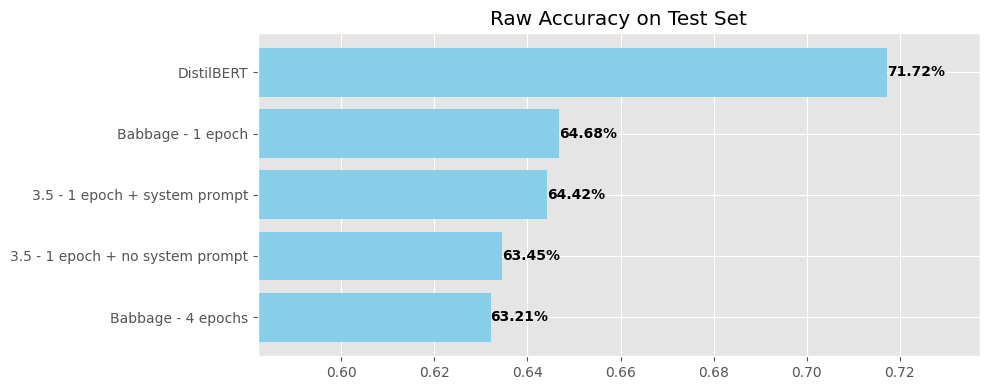

In [22]:
import matplotlib.pyplot as plt

# Find the minimum accuracy values for setting xlim
min_raw_accuracy = min(df_rounded['Raw Accuracy']) - 0.05
max_raw_accuracy = max(df_rounded['Raw Accuracy']) + 0.02

# Set the style
plt.style.use('ggplot')

# Define figure and axis for the accuracy plot
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust the figure size as needed

df_rounded.sort_values('Raw Accuracy', inplace=True, ascending=True)

ax.barh(df_rounded['Model Description'], df_rounded['Raw Accuracy'], color='skyblue')
ax.set_title('Raw Accuracy on Test Set')
ax.set_xlim(min_raw_accuracy, max_raw_accuracy)  # Extend the x-axis
for i, v in enumerate(df_rounded['Raw Accuracy']):
    ax.text(v, i, "{:,.2f}%".format(v * 100), va='center', ha='left', fontweight='bold')

# Adjust the layout
plt.tight_layout()

# Show the plot for accuracy
plt.show()

## Modeli Kaydet

In [24]:
trainer.save_model("my_finetuned_model")


Saving model checkpoint to my_finetuned_model
Configuration saved in my_finetuned_model/config.json
Model weights saved in my_finetuned_model/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in my_finetuned_model/tokenizer_config.json
Special tokens file saved in my_finetuned_model/special_tokens_map.json


## Modelin Kullanılması

In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_path = "my_finetuned_model"  # modeli kaydettiğiniz klasörün yolu

# Modeli yükleme
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Tokenizer yükleme
tokenizer = AutoTokenizer.from_pretrained(model_path)


loading configuration file my_finetuned_model/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "vocab_size": 28996
}

loading weights file my_finetuned_model/model.safetensors
All model checkpoint weights we

In [59]:
dataset[9434]

{'package_name': 'ch.blinkenlights.battery',
 'review': 'S.v.enterprise Nice',
 'date': 'February 09 2015',
 'star': 3}

In [48]:
def predict_star(text):
    # 1. Metni tokenize et
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

    # 2. Modeli çalıştır (inference)
    with torch.no_grad():
        outputs = model(**inputs)

    # 3. Çıktı (logits) üzerinden en yüksek skora sahip sınıfı bul
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()

    return predicted_class_id

# Örnek kullanım:
test_text = "The bandwidth seemed to be limited to maximum 2 MHz or so. I tried to increase the bandwidth but not possible. I purchased this is because one of the pictures in the advertisement showed the 2.4GHz band with around 10MHz or more bandwidth. Is it not possible to increase the bandwidth? If not  it is just the same performance as other free APPs."
predicted_label = predict_star(test_text)
print("Tahmin edilen yıldız sınıfı:", predicted_label)


Tahmin edilen yıldız sınıfı: 2


In [51]:
test_text = "Works with RTL and Nextbook Aries 8. Demod stops working if the scan width is changed requiring restart."
predicted_label = predict_star(test_text)
print("Tahmin edilen yıldız sınıfı:", predicted_label)

Tahmin edilen yıldız sınıfı: 2


In [56]:
test_text = "hi hola"
predicted_label = predict_star(test_text)
print("Tahmin edilen yıldız sınıfı:", predicted_label)

Tahmin edilen yıldız sınıfı: 4


In [ ]:
test_text = "hi hola"
predicted_label = predict_star(test_text)
print("Tahmin edilen yıldız sınıfı:", predicted_label)

In [63]:
text_x = dataset[9434]["review"]
print(text_x)

S.v.enterprise Nice


In [70]:
text_x = dataset[9434]["star"]
print(text_x)

3


In [74]:
dataset[1000]

{'package_name': 'org.tomdroid',
 'review': 'Yay! Hugely useful! Less hype and glitz better service. Deserves every star.',
 'date': 'April 05 2014',
 'star': 4}

In [73]:
say = 1000
for text_x in dataset[say:1050]["review"]:
    print(say)
    print(text_x)
    predicted_label = predict_star(text_x)
    print("Tahmin edilen yıldız sınıfı:", predicted_label)
    star_x = dataset[say]["star"]
    say=say+1
    print("Gerçek olan Puan: " ,star_x )


1000
Yay! Hugely useful! Less hype and glitz better service. Deserves every star.
Tahmin edilen yıldız sınıfı: 4
Gerçek olan Puan:  4
1001
Nice app but little disappointed Creates notes well. But syncs from its single folder. So when syncing it reads notes but not notebooks. That makes it incomplete as the main purpose is using it with Tomboy notes from Linux. Please make this happen :) Update: as reported in launchpad this will be a feature in the next 0.8 release.
Tahmin edilen yıldız sınıfı: 3
Gerçek olan Puan:  3
1002
Getting much better - keep it up! As a longtime user of tomboy on Linux I need to have easy access on my Nexus Tablet. This now almost does it all. Congratulations. Synching still is not totally intuitive yet but getting better all the time with each new release.
Tahmin edilen yıldız sınıfı: 4
Gerçek olan Puan:  3
1003
Worthy Attempt Not very usable without feasible sync and notebook support. rainy server is not something the avg user can install. As is  presents a ra

In [75]:
say = 1000


results = []
for text_x in dataset[say:1500]["review"]:

    print(say)
    print(text_x)
    predicted_label = predict_star(text_x)
    print("Tahmin edilen yıldız sınıfı:", predicted_label)
    star_x = dataset[say]["star"]
    say=say+1
    print("Gerçek olan Puan: " ,star_x )
    sonuc = {

             'etiket':say,
             'tahmin':predicted_label,
             'gercek':star_x

             }

    results.append(sonuc)






results

1000
Yay! Hugely useful! Less hype and glitz better service. Deserves every star.
Tahmin edilen yıldız sınıfı: 4
Gerçek olan Puan:  4
1001
Nice app but little disappointed Creates notes well. But syncs from its single folder. So when syncing it reads notes but not notebooks. That makes it incomplete as the main purpose is using it with Tomboy notes from Linux. Please make this happen :) Update: as reported in launchpad this will be a feature in the next 0.8 release.
Tahmin edilen yıldız sınıfı: 3
Gerçek olan Puan:  3
1002
Getting much better - keep it up! As a longtime user of tomboy on Linux I need to have easy access on my Nexus Tablet. This now almost does it all. Congratulations. Synching still is not totally intuitive yet but getting better all the time with each new release.
Tahmin edilen yıldız sınıfı: 4
Gerçek olan Puan:  3
1003
Worthy Attempt Not very usable without feasible sync and notebook support. rainy server is not something the avg user can install. As is  presents a ra

[{'etiket': 1001, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1002, 'tahmin': 3, 'gercek': 3},
 {'etiket': 1003, 'tahmin': 4, 'gercek': 3},
 {'etiket': 1004, 'tahmin': 0, 'gercek': 1},
 {'etiket': 1005, 'tahmin': 2, 'gercek': 1},
 {'etiket': 1006, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1007, 'tahmin': 3, 'gercek': 2},
 {'etiket': 1008, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1009, 'tahmin': 2, 'gercek': 2},
 {'etiket': 1010, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1011, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1012, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1013, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1014, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1015, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1016, 'tahmin': 4, 'gercek': 3},
 {'etiket': 1017, 'tahmin': 0, 'gercek': 0},
 {'etiket': 1018, 'tahmin': 4, 'gercek': 3},
 {'etiket': 1019, 'tahmin': 0, 'gercek': 1},
 {'etiket': 1020, 'tahmin': 4, 'gercek': 4},
 {'etiket': 1021, 'tahmin': 4, 'gercek': 3},
 {'etiket': 1022, 'tahmin': 4, 'gercek': 4},
 {'etiket'

In [77]:
import pandas as pd
df_result = pd.DataFrame(results)
df_result

,etiket,tahmin,gercek
0,1001,4,4
1,1002,3,3
2,1003,4,3
3,1004,0,1
4,1005,2,1
...,...,...,...
495,1496,4,2
496,1497,4,0
497,1498,0,0
498,1499,4,4


In [78]:
df_result.to_excel("Result_df.xlsx")